In [2]:
from nipype.interfaces import spm

spm.SPMCommand.set_mlab_paths(paths='/home/anton/Apps/SPM/spm12/')
spm.SPMCommand().version

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


'12.7771'

In [34]:
# realign = spm.Realign()
# realign.inputs.in_files = '/run/media/anton/AntonData1/PNC/MRI/600009963128/FMRI_BOLD_emotion_identification/Dicoms/Dicoms_bbl1_idemo2_210_0_9.nii'
# realign.inputs.register_to_mean = True
# realign.run()

norm12 = spm.Normalize12()
norm12.inputs.image_to_align = '/run/media/anton/AntonData1/PNC/MRI/600009963128/FMRI_BOLD_emotion_identification/Dicoms/rDicoms_bbl1_idemo2_210_0_9.nii'
norm12.inputs.apply_to_files = '/run/media/anton/AntonData1/PNC/MRI/600009963128/FMRI_BOLD_emotion_identification/Dicoms/rDicoms_bbl1_idemo2_210_0_9.nii'
norm12.run()

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


In [17]:
import numpy as np
from nilearn import image

# Load power template coords
powerfile = '/home/anton/Documents/Tulane/Hackathon/power264/power264MNI.nii.gz'

powerimg = image.load_img(powerfile)
datpower = image.get_data(powerimg)

print(datpower.shape)

(91, 109, 91)


In [18]:
# Sort power coordinates

pcoords = []
proinums = []

for roi in range(264):
    x,y,z = np.where(datpower == roi+1)
    pcoords.append(np.stack([x,y,z,np.ones(x.shape[0])]).T)
    proinums.append(roi*np.ones(x.shape[0]))
    
pcoords = np.concatenate(pcoords).T
proinums = np.concatenate(proinums)

print(pcoords.shape)
print(proinums.shape)

(4, 21384)
(21384,)


In [35]:
# SPM-created volumes

import re

def get_sub(sub):
    return re.search('MRI/([0-9]+)', sub)[1]

spm1 = '/run/media/anton/AntonData1/PNC/MRI/600009963128/FMRI_BOLD_emotion_identification/Dicoms/wrDicoms_bbl1_idemo2_210_0_9.nii'

subs = [spm1]
print(get_sub(spm1))

600009963128


In [36]:
from scipy.interpolate import interpn

tsdict = dict()

for i,sub in enumerate(subs):
    if i % 20 == 0:
        print(f'Running {i} {sub}')

    # Load the nii image
    imgname = sub
    img = image.load_img(imgname)
    datimg = image.get_data(img)

    # Transform coords from power image space to nii image space
    coords = np.linalg.inv(img.affine)@powerimg.affine@pcoords
    points = [np.arange(s) for s in img.shape[:-1]]

    # Set up data structures
    nt = datimg.shape[-1]
    ts = np.zeros((264,nt))
    res = np.zeros((nt,coords.shape[-1]))

    # Interpolate fractional coords
    for tp in range(nt):
        res[tp] = interpn(points, datimg[:,:,:,tp], coords[:-1].T, bounds_error=True)

    # Each roi composed of mean of a ball of coordinates
    for roi in range(264):
        ts[roi] = np.mean(res[:,proinums == roi], axis=1)

    tsdict[get_sub(sub)] = ts
    
print(list(tsdict.keys()))

Running 0 /run/media/anton/AntonData1/PNC/MRI/600009963128/FMRI_BOLD_emotion_identification/Dicoms/wrDicoms_bbl1_idemo2_210_0_9.nii
['600009963128']


In [37]:
from scipy import signal

def butter_bandpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = [cutoff[0] / nyq, cutoff[1] / nyq]
    b, a = signal.butter(order, normal_cutoff, btype='band', analog=False)
    return b, a

def butter_bandpass_filter(data, cutoff, fs, order=5):
    b, a = butter_bandpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

ts = tsdict[get_sub(spm1)]

tr = 3

filt_ts = butter_bandpass_filter(ts, [0.01, 0.15], 1/tr)

print('Done')

Done


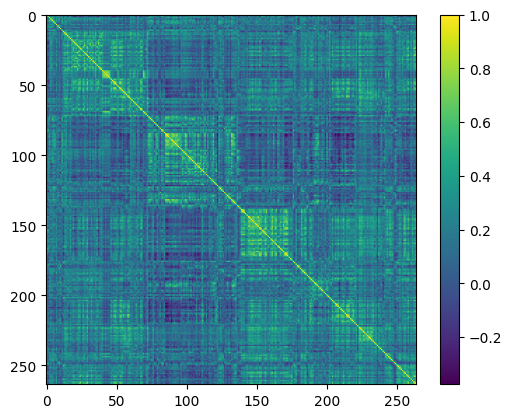

In [38]:
import matplotlib.pyplot as plt

p = np.corrcoef(filt_ts)

plt.imshow(p)
plt.colorbar()
plt.show()

In [39]:
# Check against existing ts and FC

import pickle

oldts = pickle.load(open('../../PNC_Good/PNC_PowerTS_float2.pkl', 'rb'))

print(f'sub-{get_sub(spm1)}' in list(oldts['emoid'].keys()))

True


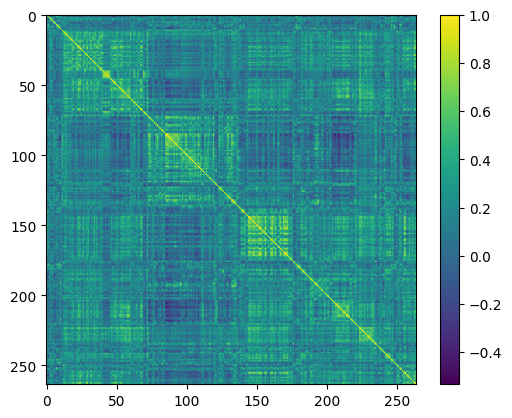

In [40]:
ots = oldts['emoid'][f'sub-{get_sub(spm1)}']
filt_ts = butter_bandpass_filter(ots, [0.01, 0.15], 1/tr)
op = np.corrcoef(filt_ts)

plt.imshow(op)
plt.colorbar()
plt.show()

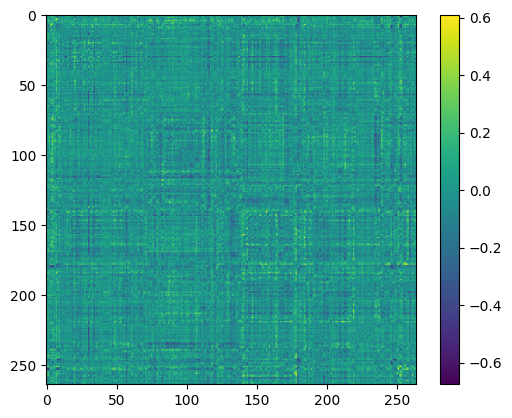

In [41]:
# Difference between SPM and fmriprep

plt.imshow(p-op)
plt.colorbar()
plt.show()